<a href="https://colab.research.google.com/github/arnauldnzegha/deep2pde_Berg_Nystrom/blob/master/Berg_Nystrom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Berg&Nystrom 2019 paper

Paper link in Journal of Computational Physics: https://www.sciencedirect.com/science/article/pii/S0021999119300944

Arxiv link: https://arxiv.org/abs/1808.10788

There are some differences between the two papers (like the NN architecture used).



## Implementation of the interpolated version


In [0]:
from keras import backend as K 
from keras.models import Model
import math as M
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adadelta
from keras.layers import Dense, Input
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import scipy.io
from keras.regularizers import l1
from sklearn.neural_network import MLPRegressor
from random import shuffle

Functions implementations

*** burgers_sine.mat*** : https://drive.google.com/file/d/1NOYWXhdm6i3zyU5nbcteS617lCDKyc7P/view?usp=sharing

Download the file on your local drive then execute the next code to upload it on colab.
The file content a compiled matrix of data

In [0]:
from google.colab import files
files.upload()

Saving burgers_sine.mat to burgers_sine (1).mat


{'burgers_sine.mat': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jan 15 19:50:44 2018                                        \x00\x00\x00\x00\x00\x00\x00\x00\x00\x01IM\x0f\x00\x00\x00\xd9\x01\x00\x00x\x9c5\xcc\xcbjSQ\x14\x06\xe0\x9d6I\x934MsON\xee\x17\xdf\xc0\x07\xc8\x19:\xf09|\x02\x07\x0e}\x8d\xf8\x06\x8e3r\xec\xa8\x10A\x10\x04\xc1\x81b\t\x8a"U\xabV\xad\x97$\xfbsq\x0e\x8b\xbd\xd6\xb7\xfeJ\x08\xe1^>\x84\xed\x17\n!\xf6]\xe5\xbc3\xdb\xffl\xdf3\xe1\xee\xb6\x17\xb7\xff\xad\xffh[\x0f\x96\xbbz\xb8\x88\xfd\xd1\xe2\xe6\xbe\x1e{\x9f-\xa2zj\xfelqg_\xcf\xed_,\x9e\xacw\xf5\x92{e\xfe\x9a\x7fc\x7f\xeen\xc3\xbd\xe5\xdeq\xef\xb9\x0f\xdcG\xee\xc2\xfc\x82\xffd\xff\xd9\xdd\x17\xee\x92\xbb\xe4\xber\xdf\xb8\xef\xdc\x15w\xc5\xfd\xe0~r\xbf\xb8k\xee\x9a\xfb\xcd\xfd\xe1\xfer!\x8d\xf3\x90F\x1f\xd2\xb8\xcf\xa4\xf1.\x93Fv\xc0\x1dp\x07\xdc!w\xc8e\xb9,\x97\xe5r\\\x8e\xcbsy.\xcf\x1dqG\\\x81+p\x05\xae\xc8\x15\xb9\x12W\xe2J\xdc1w\xcc\x95\xb92W\xe6N\xb8\x13\xae\xc2U\xb8\nw\xca\x9drU\xf3*_\xb5\xaf\xba\xabr

the **getBurgersData( test  )** function retrieves the data in the **burgers_sine.mat** file and puts it in an array [x_values,  time_values] and an array [U_value].
These datas in *** burgers_sine.mat file***  are generated by a solution of the burgers equation.

In [0]:
def getBurgersData(test=0.07,mix=1):
    data_sol = scipy.io.loadmat('burgers_sine.mat')  
    t_sol = data_sol['t'].flatten()[:,None]
    x_sol = data_sol['x'].flatten()[:,None]
    usol = data_sol['usol'].flatten()[:,None]
    Exact_sol = np.real(data_sol['usol'])
    T_sol, X_sol = np.meshgrid(t_sol,x_sol)
    t_sol_star = T_sol.flatten()[:,None]
    x_sol_star = X_sol.flatten()[:,None]
    X_sol_star = np.hstack((t_sol_star, x_sol_star))
    u_sol_star = Exact_sol.flatten()[:,None]
    n_train = int(len(u_sol_star)*(1-test))
    if(mix==1): X_sol_star, u_sol_star= mixData(X_sol_star, u_sol_star)
    X_train, Y_train = X_sol_star[:n_train, :],  u_sol_star[:n_train]
    X_test, Y_test = X_sol_star[n_train:, :], u_sol_star[n_train:]
    return  X_train, Y_train, X_test, Y_test

The next code mix data in a random order.
It return the same array but in a  random order.

In [0]:
def mixData(xs,ys):
    xys=[]
    for i in range(0,len(xs)-1):
        xys.append((xs[i],ys[i]))
    shuffle(xys)
    x2,y2=[],[]
    for (x,y) in xys:
        x2.append(x)
        y2.append(y)
    return (np.asarray(x2), np.asarray(y2))

The first model is a neural network (a MLP) with **5 hidden** layers and **10 units by hidden** layers.

The activation is hyperbolic tangent.
L1 regulation terme is used during de training

In [0]:
def my_model(nb_class=1):
    l1_Reg = l1(0.001)
    input_data = Input(shape=(2,))
    hidden1 = Dense(10, activation='tanh', name='l1' ,kernel_regularizer=l1_Reg)(input_data)
    hidden2 = Dense(10, activation='tanh', name='l2' ,kernel_regularizer=l1_Reg)(hidden1)
    hidden3 = Dense(10, activation='tanh', name='l3' ,kernel_regularizer=l1_Reg)(hidden2)
    hidden4 = Dense(10, activation='tanh', name='l4' ,kernel_regularizer=l1_Reg)(hidden3)
    hidden5 = Dense(10, activation='tanh', name='l5' ,kernel_regularizer=l1_Reg)(hidden4)
    output = Dense(nb_class, activation='linear', name='l6' ,kernel_regularizer=l1_Reg)(hidden5)
    model = Model(input_data, x)
    return model

In [0]:
#******************* MODEL 2 EDP***********************************************
def modelEDP(nb_class=1):
    input_data = Input(shape=(3,))
    x = Dense(2, activation='tanh', name='l1')(input_data)
    x = Dense(2, activation='tanh', name='l2')(x)
    x = Dense(nb_class, activation='linear', name='sort')(x)
    model = Model(input_data, x)
    return model
#*******************END MODEL 2 EDP*****************************************************************


**dataTrainModelEDP(X,U)** 

take a liste(** [x_value , time_val]** and** [u_value],** )  

and return a liste   **([U_value, x derivative of U, second order x derivative of U]**  and **[time derivative of U named Ut]**)

In [0]:

def dataTrainModelEDP(X,U):
    X_der=np.zeros(len(X))
    T_der=np.zeros(len(X))
    X_der2=np.zeros(len(X))
    X_train=np.zeros([len(X),3])
    for i in range(0, len(X)):
        layer_outs = get_layer_outputs(X[i])
        X_train[i][0]=U[i]
        X_train[i][1]=derivePartiel(-1,0,X[i],layer_outs,tanh_deriv)
        X_train[i][2]=derivePartiel(-1,1,X[i],layer_outs,tanh_deriv)
        X_der2[i]=derivePartiel(-1,0,X[i],layer_outs, tanh_deriv2)
    return X_train, X_der2

This code returne in a list the output of each layer after a prediction.

In [0]:
def get_layer_outputs(test_data):
    test_data=test_data.reshape(1,2,)
    ar=np.float32(test_data)
    test_data2=[[ar]]
    outputs = [layer.output for layer in model.layers[1:]]
    functors = [K.function([model.input, K.learning_phase()], [out]) for out in outputs] 
    layer_outs = [func([test_data, 1.]) for func in functors]
    return test_data2+layer_outs

**tanh_deriv** return the derivative of tanh. $$th' = (1-th^2)$$


**tanh_deriv2** return the second order derivative  $$th' ' =  -2(th - th^3)$$


In [0]:
#******************* DERIVEE  *******************************************
def tanh_deriv(x):
    return(1-(M.tanh(x))**2)

def tanh_deriv2 (x):
    return(-2*(M.tanh(x) -(M.tanh(x))**3))
#*******************END DERIVEE  *******************************************

In [0]:
#******************* DERIVATION 2***********************************************
def derivePartiel(layer, n_i, inputX, layer_outs, fct_deriv):
    nb_l=len(model.layers)
    if((layer)>(-1*nb_l)):
        ln=len(model.layers[layer].get_weights()[0][0])
        if((layer-1)>(-1*nb_l)):
            inp=len(model.layers[layer-1].get_weights()[0][0])
        else:
            inp=len(inputX)
        Lpartial=np.zeros(ln)
        LpartialN=derivePartiel(layer-1 ,n_i, inputX,layer_outs, fct_deriv)
        chaine=0
        for n in range(0,ln):
            act=model.layers[layer].get_weights()[1][n]
            chaine=0
            for i in range(0,inp):
                W=model.layers[layer].get_weights()[0][i][n]
                act+=W*layer_outs[layer-1][0][0][i]
                chaine+=W*LpartialN[i]
            if (layer==-1):
                Lpartial[n]=chaine
            else:
                Lpartial[n] = fct_deriv(act)*chaine
        return Lpartial
    else:
        Lpartial=np.zeros(len(inputX))
        Lpartial[n_i]=1
        return Lpartial
#*******************END DERIVATION*****************************************************************


###Using Keras

The training phase with SDG and the mean squared error.


In [0]:
model = my_model()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['accuracy'])
X_train, Y_train, X_test, Y_test= getBurgersData()
hist=model.fit(X_train, Y_train, validation_split=0.15, batch_size=500, epochs=1000, verbose=1)

train M1
Instructions for updating:
Use tf.cast instead.
Train on 40675 samples, validate on 7179 samples
Epoch 1/1000
40675/40675 [==============================] - 3s 75us/step - loss: 0.2313 - acc: 4.9170e-05 - val_loss: 0.1582 - val_acc: 1.3930e-04
Epoch 2/1000
40675/40675 [==============================] - 0s 7us/step - loss: 0.1361 - acc: 4.9170e-05 - val_loss: 0.1287 - val_acc: 1.3930e-04
Epoch 3/1000
40675/40675 [==============================] - 0s 7us/step - loss: 0.1263 - acc: 4.9170e-05 - val_loss: 0.1235 - val_acc: 1.3930e-04
Epoch 4/1000
40675/40675 [==============================] - 0s 7us/step - loss: 0.1219 - acc: 4.9170e-05 - val_loss: 0.1195 - val_acc: 1.3930e-04
Epoch 5/1000
40675/40675 [==============================] - 0s 7us/step - loss: 0.1179 - acc: 4.9170e-05 - val_loss: 0.1155 - val_acc: 1.3930e-04
Epoch 6/1000
40675/40675 [==============================] - 0s 7us/step - loss: 0.1143 - acc: 4.9170e-05 - val_loss: 0.1120 - val_acc: 1.3930e-04
Epoch 7/1000
4067

In [0]:
model2 = modelEDP()
model2.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['accuracy'])
X_train2, Y_train2=X_train[:10, :], Y_train[:10,]
Uxx, Ut=dataTrainModelEDP(X_train2, Y_train2)    
hist=model2.fit(Uxx, Ut, validation_split=0.1, batch_size=1000, epochs=5, verbose=1)

Test of prédiction of the model trained using keras

I just the prediction to see if it is close to u_val.


In [0]:
U=Y_test[10:]
y_pred = model.predict(X_test[10:])
print("Prediction Reseau 1 && U(x,t)")
for i in range(0,5):
  print(str(y_pred[i])+" && " +str(U[i]))

y_pred2 = model2.predict(Uxx[:10, :])
print("Prediction Reseau 2 && Ut")
for i in range(0,5):
  print(str(y_pred2[i])+" && " +str(Ut[i]))

Prediction Reseau 1 && U(x,t)
[0.33139455] && [0.37990802]
[-0.4012279] && [-0.3488663]
[-0.8162141] && [-0.75071328]
[0.8513379] && [0.89303898]
[0.18537514] && [0.20946535]
Prediction Reseau 2 && Ut
[0.46708608] && 0.03215322925789649
[0.09031936] && 2.1270094952326378e-05
[-0.02448095] && 9.829288275789794e-07
[0.480093] && 0.06484898317655044
[0.34908044] && 0.00907946172348252


###Using SKlearn



Train the model using Sklearn

In [0]:
""" model compilation """
X_train, Y_train, X_test, Y_test= getBurgersData()
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10, 10), random_state=1, max_iter=2000)
model.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10, 10, 10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Test the model trained using sklearn

In [0]:
X_train, Y_train, X_test, Y_test= getBurgersData(mix=0)
U=Y_test[10:]
y_pred = model.predict(X_test[10:])
print("Prediction Reseau 1 && U(x,t)")
for i in range(0,5):
  print(str(y_pred[i])+" && " +str(U[i]))

"""y_pred2 = model2.predict(Uxx[:10, :])
print("Prediction Reseau 2 && Ut")
for i in range(0,5):
  print(str(y_pred2[i])+" && " +str(Ut[i]))"""

Prediction Reseau 1 && U(x,t)
-0.2890496373262328 && [-0.28705144]
-0.2841408538102124 && [-0.28343906]
-0.2792320702941915 && [-0.27991554]
-0.2743232867781717 && [-0.27647771]
-0.26941450326215016 && [-0.27312253]


'y_pred2 = model2.predict(Uxx[:10, :])\nprint("Prediction Reseau 2 && Ut")\nfor i in range(0,5):\n  print(str(y_pred2[i])+" && " +str(Ut[i]))'

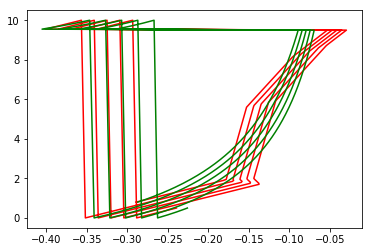

In [0]:



X_test3=X_test[:1000,:1].reshape(-1)
y_pred2=y_pred[:1000].reshape(-1)
plt.plot(y_pred2, X_test3, 'r')




y_pred2=U[:1000].reshape(-1)
plt.plot(y_pred2, X_test3,'g')

In [0]:
def get_activations(clf, X):
        hidden_layer_sizes = clf.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        layer_units = [X.shape[1]] + hidden_layer_sizes + \
            [clf.n_outputs_]
        activations = [X]
        for i in range(clf.n_layers_ - 1):
            activations.append(np.empty((X.shape[0],
                                         layer_units[i + 1])))
        clf._forward_pass(activations)
        return activations

In [0]:
#out=get_activations(clf, X)